# User input

You are free to change these parameters accordingly:

In [1]:
dataset = '/content/drive/My Drive/Colab Notebooks/Project3/nasdaq2007_17.csv' # path to the dataset
load_mod = True # change to False if you want to train a new model
dir = '/content/drive/My Drive/Colab Notebooks/Project3/Saves/' # the directory to which the model will be save or from which it will be loaded
model_name = 'compressor.h5' # file name of saved model (file must be of type .h5)

# Includes

In [2]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras import regularizers
import time
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import keras
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Utils

In [3]:
test_samples = 2000
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

# Dataset loading and editing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

print('Python version ' + sys.version)
print("---------------------------------------")

df = pd.read_csv(dataset, delimiter='\t', header=None)

df.rename(columns = {0:'id'}, inplace=True) #rename the first column to "id"
print(df.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python version 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Columns: 3651 entries, id to 3650
dtypes: float64(3650), object(1)
memory usage: 10.0+ MB
None


Set seed for reproductability:

In [5]:
import os
import random
import tensorflow

def reproducibleResults(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

reproducibleResults(12345)

# Model creation and training

Shuffle the dataset and the split it to train and test sets:

In [6]:
df.drop("id", axis=1, inplace=True)
df.sample(frac=1, random_state=1).reset_index(drop=True)

split_index = int(df.shape[0]*0.9)

train = df.head(split_index)
test = df.tail(df.shape[0]-split_index).reset_index(drop=True)
print(train.shape, test.shape)

(323, 3650) (36, 3650)


Transpose the sets for our convinience:

In [7]:
train = train.transpose()
test = test.transpose()
print(test.head())

       0       1       2       3   ...      32      33      34      35
1  11.440  27.255  16.375  16.111  ...  36.388  8.2660  46.395  47.669
2  11.660  26.262  16.528  15.638  ...  35.203  8.3172  45.815  46.668
3  11.825  26.171  16.520  15.618  ...  35.707  8.2781  42.181  46.570
4  11.275  26.152  15.829  15.747  ...  35.104  8.3591  41.582  46.974
5  10.780  27.464  15.796  15.884  ...  36.282  8.2781  43.444  47.004

[5 rows x 36 columns]


Perform scaling:

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

for i in range(train.shape[1]):
  curr_ts = train[i].to_numpy()
  curr_ts = curr_ts.reshape(-1,1)
  train[i] = scaler.fit_transform(curr_ts)

for i in range(test.shape[1]):
  curr_ts = test[i].to_numpy()
  curr_ts = curr_ts.reshape(-1,1)
  test[i] = scaler.transform(curr_ts)

print(train.shape, test.shape)

(3650, 323) (3650, 36)


Split to X and y:

In [9]:
import numpy as np

def create_dataset(X, time_steps=1, lag=1):
    Xs, ys = [], []
    for j in range(len(X.columns)):
      for i in range(0, len(X) - time_steps, lag):
          v = X[j].iloc[i:(i + time_steps)].values
          Xs.append(v)
          ys.append(X[j].iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
WINDOW = 50
LAG = 10

# reshape to (samples, window, n_features)

X_train, y_train = create_dataset(train, WINDOW, LAG)
X_test, y_test = create_dataset(test, WINDOW)

X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

print(X_train.shape)
print(y_train.shape)

(116280, 50, 1)
(116280,)


In [11]:
print(X_test.shape)
print(y_test.shape)

(129600, 50, 1)
(129600,)


Train the model:

In [12]:
if load_mod == False:
  input_window = Input(shape=(WINDOW,1))
  x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
  #x = BatchNormalization()(x)
  x = MaxPooling1D(2, padding="same")(x) # 5 dims
  x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
  #x = BatchNormalization()(x)
  encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

  encoder = Model(input_window, encoded)

  # 3 dimensions in the encoded layer

  x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
  #x = BatchNormalization()(x)
  x = UpSampling1D(2)(x) # 6 dims
  x = Conv1D(16, 2, activation='relu')(x) # 5 dims
  #x = BatchNormalization()(x)
  x = UpSampling1D(2)(x) # 10 dims
  decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
  model = Model(input_window, decoded)

  model.compile(optimizer='adam', loss='binary_crossentropy')
  history = model.fit(X_train, X_train,
                  epochs=10,
                  batch_size=32,
                  shuffle=True,
                  validation_data=(X_test, X_test))
  !pip install h5py pyyaml
  full_path = dir + model_name
  model.save(full_path)

if load_mod == True:
  full_path = dir + model_name
  model = keras.models.load_model(full_path)

model.summary()
decoded_stocks = model.predict(X_test)

Epoch 1/10
3634/3634 [==============================] - 28s 7ms/step - loss: 0.5200 - val_loss: 0.4446
Epoch 2/10
3634/3634 [==============================] - 27s 7ms/step - loss: 0.5071 - val_loss: 0.4363
Epoch 3/10
3634/3634 [==============================] - 28s 8ms/step - loss: 0.5066 - val_loss: 0.4302
Epoch 4/10
3634/3634 [==============================] - 27s 8ms/step - loss: 0.5065 - val_loss: 0.4289
Epoch 5/10
3634/3634 [==============================] - 27s 8ms/step - loss: 0.5064 - val_loss: 0.4279
Epoch 6/10
3634/3634 [==============================] - 27s 8ms/step - loss: 0.5064 - val_loss: 0.4280
Epoch 7/10
3634/3634 [==============================] - 27s 8ms/step - loss: 0.5064 - val_loss: 0.4256
Epoch 8/10
3634/3634 [==============================] - 27s 7ms/step - loss: 0.5063 - val_loss: 0.4253
Epoch 9/10
3634/3634 [==============================] - 27s 8ms/step - loss: 0.5063 - val_loss: 0.4254
Epoch 10/10
3634/3634 [==============================] - 30s 8ms/step - l

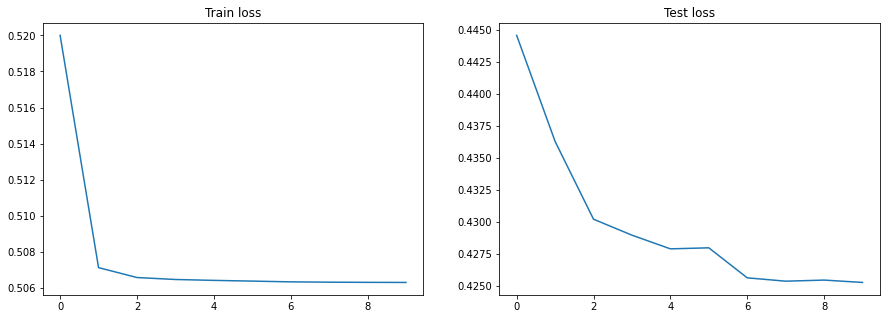

In [13]:
if load_mod == False:
  plot_history(history)

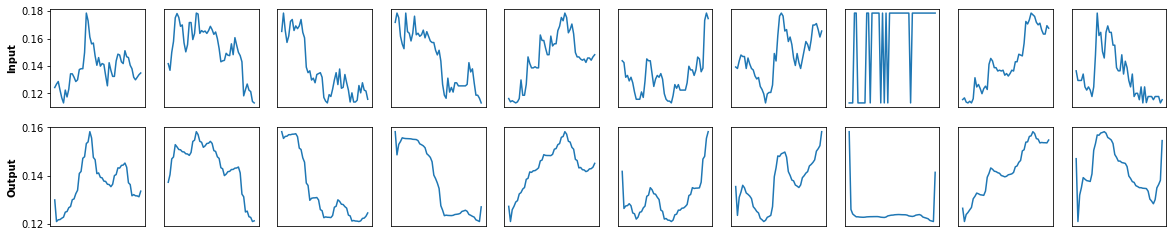

In [14]:
x_test_deep = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
plot_examples(x_test_deep, decoded_stocks)